In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model


import pandas as pd
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from google.colab import drive 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

drive.mount('/content/drive/')
DRIVE_FOLDER = '/content/kaggle_Cancer/'



Mounted at /content/drive/


In [ ]:
#!unzip /content/drive/MyDrive/kaggle_Cancer/histopathologic-cancer-detection.zip -d /content/drive/MyDrive/kaggle_Cancer/

In [ ]:
!unzip /content/drive/MyDrive/kaggle_Cancer/histopathologic-cancer-detection.zip -d /content/kaggle_Cancer/

In [ ]:
sample_submission = pd.read_csv(DRIVE_FOLDER+'sample_submission.csv')
train_data = pd.read_csv(DRIVE_FOLDER+'train_labels.csv')
test_data = pd.read_csv(DRIVE_FOLDER+'sample_submission.csv')

In [ ]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
test_data.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
train_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


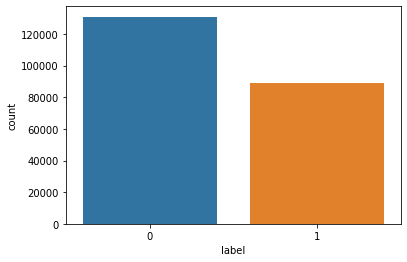

In [ ]:
sns.countplot(data=train_data, x="label")

In [ ]:
train_path = '/content/kaggle_Cancer/train/'
test_path = '/content/kaggle_Cancer/test/'

In [ ]:
#get good images


good = train_data[train_data['label'] == 0]
good.head()





,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0


# New Section

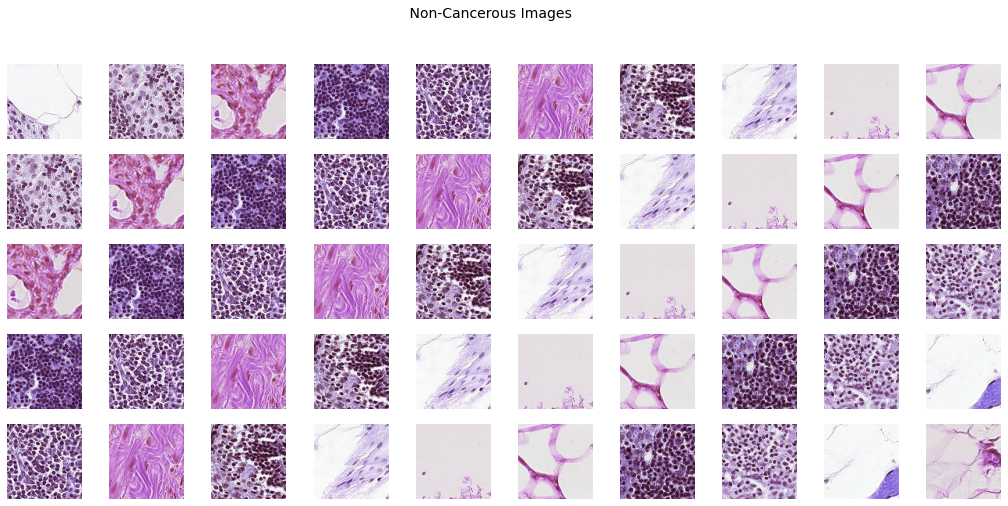

In [ ]:
n = 10
m = 5
fig, ax = plt.subplots(nrows = m, ncols = n, figsize=(18, 8))

fig.suptitle(' Non-Cancerous Images', fontsize=14)
for i in range(m):
  for j in range(n):
    img = cv.imread(train_path + good.iloc[i+j,0] +'.tif')
    ax[i,j].imshow(img)
    ax[i,j].axis('off')


In [ ]:
#get cancer images


bad = train_data[train_data['label'] == 1]
bad.head()


,id,label
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
11,c3d660212bf2a11c994e0eadff13770a9927b731,1
14,94fa32b29cc1c00403176c0795fffa3cfaa0f20e,1


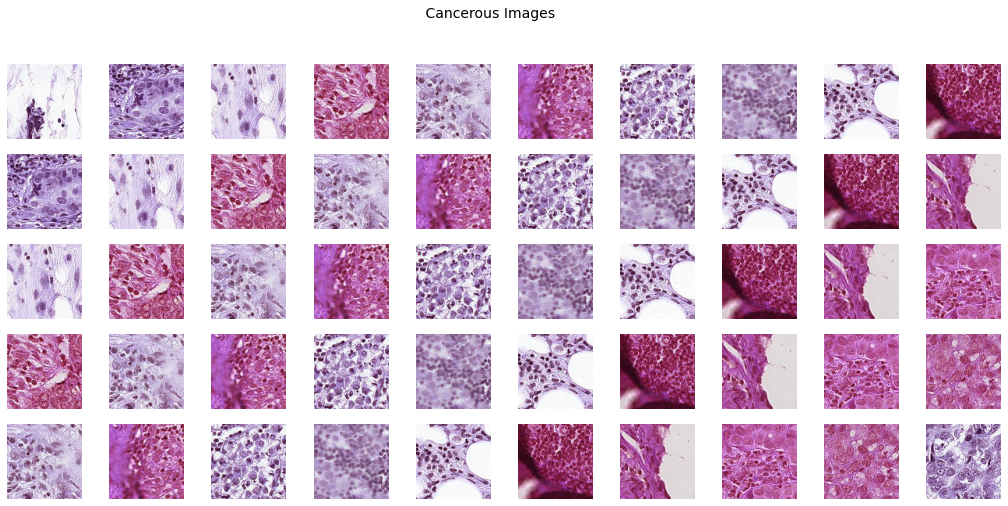

In [ ]:
n = 10
m = 5
fig, ax = plt.subplots(nrows = m, ncols = n, figsize=(18, 8))

fig.suptitle(' Cancerous Images', fontsize=14)
for i in range(m):
  for j in range(n):
    img = cv.imread(train_path + bad.iloc[i+j,0] +'.tif')
    ax[i,j].imshow(img)
    ax[i,j].axis('off')

In [ ]:
batch_size = 500
validation_split = 0.2
seed = 1234

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_df, valid_df = train_test_split(train_data, test_size = validation_split, random_state=seed, stratify=train_data.label)


In [ ]:

train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'
test_df = test_data
test_df['id'] = test_df['id'] + '.tif'

In [ ]:
#Training datagenerator

train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory = train_path, x_col = 'id', y_col = 'label', batch_size = batch_size, seed = seed, shuffle = True, class_mode = 'raw',target_size = (32,32)
)



Found 176020 validated image filenames.


In [ ]:
#Validation datagenerator


valid_gen = train_datagen.flow_from_dataframe(dataframe = valid_df, directory = train_path, x_col = 'id', y_col = 'label', batch_size = batch_size, seed = seed, shuffle = False, class_mode = 'raw',target_size = (32,32)
)


Found 44005 validated image filenames.


In [ ]:
#test generator

test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory = test_path, x_col = 'id', y_col = 'label', batch_size = batch_size, seed = seed, shuffle = False, class_mode = 'raw',target_size = (32,32)
)

Found 57458 validated image filenames.


In [ ]:
#Model CNN

model_dir = 'CNN_model_history.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=1,padding='Same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), strides=1,padding='Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(128, (3, 3), strides=1,padding='Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(256,(3,3), strides=1,padding='Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512,(3,3), strides=1,padding='Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024,(3,3), strides=1,padding='Same', activation='relu'))


model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation='relu'))


model.add(layers.Dense(256, activation='relu'))


model.add(layers.Dense(128, activation='relu'))


model.add(layers.Dense(64, activation='relu'))


model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=0.00001),metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

In [ ]:
n_epochs = 25

In [ ]:
history = model.fit(x = train_gen, steps_per_epoch = len(train_gen), workers = 8, epochs = n_epochs, validation_data = valid_gen, validation_steps = len(valid_gen), callbacks=[checkpoint], verbose = 1)

Epoch 1/25
353/353 [==============================] - ETA: 0s - loss: 0.3372 - binary_accuracy: 0.8531 - auc_3: 0.9268
Epoch 1: val_binary_accuracy did not improve from 0.83613
353/353 [==============================] - 124s 345ms/step - loss: 0.3372 - binary_accuracy: 0.8531 - auc_3: 0.9268 - val_loss: 0.3916 - val_binary_accuracy: 0.8197 - val_auc_3: 0.9120
Epoch 2/25
352/353 [============================>.] - ETA: 0s - loss: 0.3348 - binary_accuracy: 0.8549 - auc_3: 0.9279
Epoch 2: val_binary_accuracy did not improve from 0.83613
353/353 [==============================] - 121s 337ms/step - loss: 0.3348 - binary_accuracy: 0.8549 - auc_3: 0.9279 - val_loss: 0.3966 - val_binary_accuracy: 0.8197 - val_auc_3: 0.9105
Epoch 3/25
352/353 [============================>.] - ETA: 0s - loss: 0.3321 - binary_accuracy: 0.8559 - auc_3: 0.9291
Epoch 3: val_binary_accuracy did not improve from 0.83613
353/353 [==============================] - 120s 336ms/step - loss: 0.3320 - binary_accuracy: 0.8559

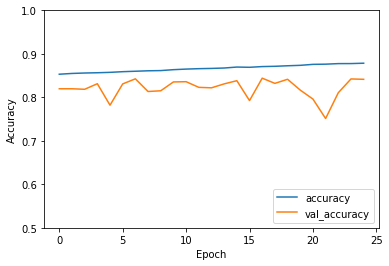

In [ ]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

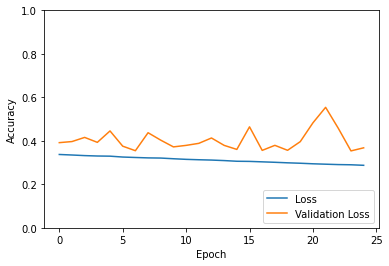

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

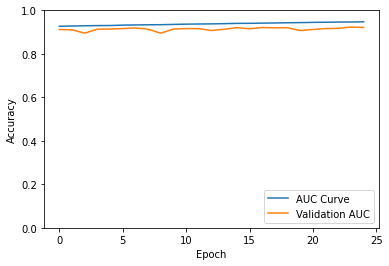

In [ ]:
plt.plot(history.history['auc_3'], label='AUC Curve')
plt.plot(history.history['val_auc_3'], label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [ ]:
model_saved = load_model('./CNN_model_history.h5')

In [ ]:
y_pred_val = model_saved.predict(valid_gen, steps=len(valid_gen_2), verbose=1)

y_pred_val = (y_pred_val > 0.5).astype('int')

y_test_val = valid_gen.labels


89/89 [==============================] - 15s 163ms/step


Accuracy Score is : 84.41%
 
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     26182
           1       0.83      0.78      0.80     17823

    accuracy                           0.84     44005
   macro avg       0.84      0.83      0.84     44005
weighted avg       0.84      0.84      0.84     44005

 


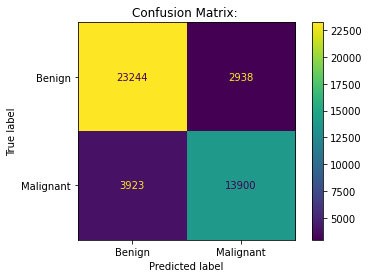

In [ ]:
accuracy = accuracy_score(y_test_val, y_pred_val) 
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_test_val, y_pred_val, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    
disp.plot()
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_test_val, y_pred_val, labels=[0, 1], zero_division=1))
print(" ")
plt.show()

In [ ]:
y_pred = model_saved.predict(test_gen)
y_pred = (y_pred > 0.5).astype('int')



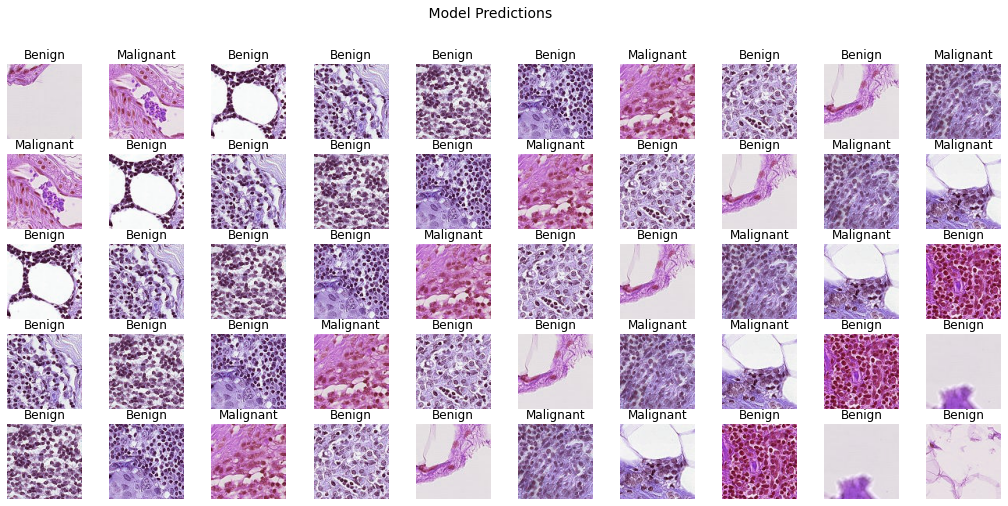

In [ ]:
n = 10
m = 5


fig, ax = plt.subplots(nrows = m, ncols = n, figsize=(18, 8))
ls = ['Benign', 'Malignant']
fig.suptitle(' Model Predictions', fontsize=14)
for i in range(m):
  for j in range(n):

    img = cv.imread(test_path + test_data.iloc[i+j,0])
  
    ax[i,j].imshow(img)
    ax[i,j].axis('off')

    ax[i,j].set_title(ls[int(y_pred[i+j])])

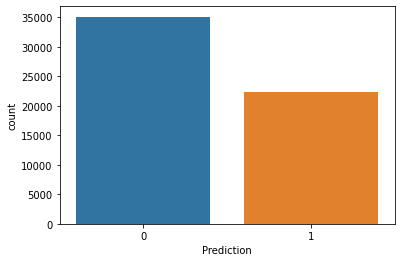

In [ ]:
index_values = np.arange(0,len(y_pred))
column_values = ['Prediction']
pred_df = pd.DataFrame(data = y_pred, index = index_values, columns = column_values)
sns.countplot(data=pred_df, x="Prediction")